https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/cohorts/2025/homework4.md

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Question 3: Predicting Strong Future Growth

### What is the CAGR for the best predictor of strong future growth (after redefining the target variable)?

# 1. Read the data

In [3]:
# download data 
# import gdown
# !gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/

In [4]:
df = pd.read_parquet('../data/stocks_df_combined_2025_06_13.parquet.brotli')
print(df.shape)
df.head()

(230262, 203)


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.061194,0.061726,0.059598,0.060130,4.789440e+07,0.0,0.0,MSFT,1986,1986-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [6]:
mask = (df.columns.str.startswith('growth_')) & (df.columns.str.find('future') < 0)
GROWTH = df.columns[mask].to_list()
GROWTH[:5]

['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d']

In [7]:
OHLCV = ['Open','High','Low','Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [8]:
TO_PREDICT = df.columns[df.columns.str.find('future') > 0].to_list()
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [9]:
# we define dummy variables on Dividends and Stock Splits events later, but drop the original abs. values
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Close_y','Dividends','Stock Splits'] + CATEGORICAL + OHLCV

In [10]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df['ln_volume'] = df['Volume'].apply(lambda x: np.log(x+ 1e-6))

In [11]:
# define columns on Dividends or Stock Splits
df['div_payout'] = (df['Dividends'] > 0).astype(int)
df['stock_split'] = (df['Stock Splits'] > 0).astype(int)

In [12]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume','div_payout','stock_split']

In [13]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md
TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [14]:
TECHNICAL_PATTERNS = df.columns[df.columns.str.find('cdl') >= 0].to_list()
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [15]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS', 'DGS1', 'DGS5', 'DGS10']

In [16]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [17]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [18]:
df['Ticker'].nunique()

33

In [19]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df[df['Date'] >='2000-01-01'].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [20]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count']).head()

,min,max,count
Ticker,,,
AAPL,2000-01-03,2025-06-13,6401
ACN,2001-07-19,2025-06-13,6012
AMZN,2000-01-03,2025-06-13,6401
ASML,2000-01-03,2025-06-13,6401
AVGO,2009-08-06,2025-06-13,3989


# 2. Create features

In [21]:
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [22]:
df['Month'] = df['Month'].dt.strftime('%B')
df['Weekday'] = df['Weekday'].astype('string')
df[CATEGORICAL].dtypes

Month                  object
Weekday        string[python]
Ticker                 object
ticker_type            object
dtype: object

In [23]:
# define week of month
df['wom'] = df['Date'].apply(lambda d: (d.day-1)//7 + 1).astype(str)

In [24]:
# check values for week-of-month (should be between 1 and 5)
df['wom'].value_counts()

wom
2    45083
3    44006
4    43753
1    43557
5    15396
Name: count, dtype: int64

In [25]:
df['month_wom'] = df['Month'] + '_w' + df['wom']
df['month_wom'].head()

3490    January_w1
3491    January_w1
3492    January_w1
3493    January_w1
3494    January_w1
Name: month_wom, dtype: object

In [26]:
# del wom temp variable
del df['wom']

In [27]:
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [28]:
def get_df_dummy(df, cat_columns):
    # Generate dummy variables (no need for bool, let's have int32 instead)
    df_dummy = pd.get_dummies(df[cat_columns], dtype='int32')
    return pd.concat([df, df_dummy], axis=1), df_dummy.columns.to_list()  

In [29]:
df_full, DUMMIES = get_df_dummy(df, CATEGORICAL)
print(df_full.shape)
df_full.head()

(191795, 322)


,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,month_wom_October_w1,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5
3490,35.975752,36.358881,34.328300,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,0
3491,34.807221,35.899137,34.404936,34.519875,54119000.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,0
3492,34.060124,35.669264,33.523744,34.883850,64059600.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,0
3493,34.385780,34.903004,33.217238,33.715305,54976600.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,0
3494,33.293845,34.404917,32.891561,34.155884,62013600.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 322 entries, Open to month_wom_September_w5
dtypes: datetime64[ns](2), float64(130), int32(178), int64(7), object(4), string(1)
memory usage: 342.4+ MB


In [31]:
df_full[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 301 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(3)
memory usage: 312.4 MB


__Look at the distribution of `growth_future_30d` and `is_positive_growth_30d_future`.__

Text(0.5, 1.0, 'median 1.022')

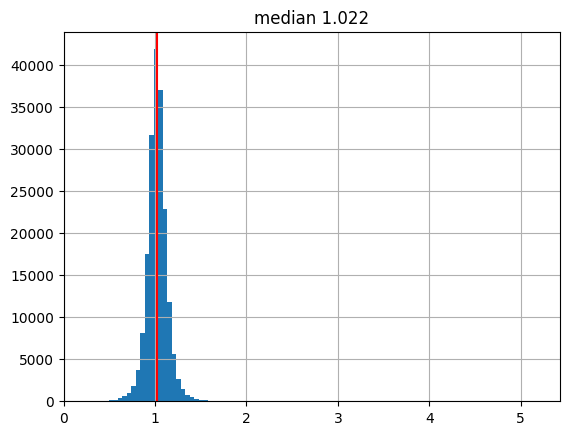

In [32]:
median_growth = df_full['growth_future_30d'].median()
df_full['growth_future_30d'].hist(bins=100)
plt.axvline(median_growth, c='r')
plt.title(f'median {median_growth:.3f}')

In [33]:
df_full[['growth_future_30d','is_positive_growth_30d_future']].describe().T

,count,mean,std,min,25%,50%,75%,max
growth_future_30d,190805.0,1.024153,0.116592,0.246131,0.961696,1.021542,1.083104,5.179689
is_positive_growth_30d_future,191795.0,0.592956,0.491284,0.000000,0.000000,1.000000,1.000000,1.000000


The median for growth_future_30d is around 1.02 (2%), and the top 25% starts at about 1.08 (8%). The current version of is_positive_growth_30d_future has about 60% of records labeled as class 1 (when defined as 1 when growth_future_30d>1)

### Redefine is_positive_growth_30d_future to equal 1, if growth_future_30d >= 1.08; otherwise, 0

In [34]:
df_full['is_positive_growth_30d_future'] = df_full['growth_future_30d'].apply(lambda x: 1 if x >=1.08 else 0)
df_full['is_positive_growth_30d_future'].mean()

np.float64(0.2592611903334289)

# 3. Split the data

In [35]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [36]:
min_date_df = df_full['Date'].min()
max_date_df = df_full['Date'].max()

df_full = temporal_split(df_full, min_date = min_date_df, max_date = max_date_df)

In [37]:
df_full['split'].value_counts(normalize=True)*100

split
train         67.639928
test          16.375818
validation    15.984254
Name: proportion, dtype: float64

In [38]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [39]:
def split_data(df, features, target='is_positive_growth_30d_future'):
    
    train_valid_df = df[df['split'].isin(['train','validation'])]
    test_df = df[df['split'].isin(['test'])]
    
    # ONLY numerical Separate features and target variable for training and testing sets
    X_train_valid = train_valid_df[features_list+[to_predict]].copy()
    X_test = test_df[features_list+[to_predict]].copy()
    
    # this to be used for predictions and join to the original dataframe new_df
    X_all =  df[features_list+[to_predict]].copy()
    
    print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')

    # Clean from +-inf and NaNs:
    X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
    y_train_valid = X_train_valid.pop(to_predict).values
    
    X_test = clean_dataframe_from_inf_and_nan(X_test)
    y_test = X_test.pop(to_predict).values
    
    X_all = clean_dataframe_from_inf_and_nan(X_all)
    y_all =  X_all.pop(to_predict).values

    return X_train_valid, y_train_valid, X_test, y_test, X_all, y_all

In [40]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES

# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

X_train_valid, y_train_valid, X_test, y_test, X_all, y_all = split_data(df_full, features_list, to_predict)

length: X_train_valid (160387, 302),  X_test (31408, 302), all combined: X_all (191795, 302)


# 4. Decision Tree Classifier

In [41]:
%%time
model_dt = DecisionTreeClassifier(max_depth=10, random_state=42)
model_dt.fit(X_train_valid, y_train_valid)

CPU times: user 24.6 s, sys: 101 ms, total: 24.7 s
Wall time: 24.3 s
Parser   : 108 ms


DecisionTreeClassifier(max_depth=10, random_state=42)

In [42]:
df_full['proba_dt'] = model_dt.predict_proba(X_all)[:,1]
df_full['pred_dt'] = model_dt.predict(X_all)

In [43]:
n_nodes = model_dt.tree_.node_count
n_leaves = model_dt.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 1269
Number of leaves: 635


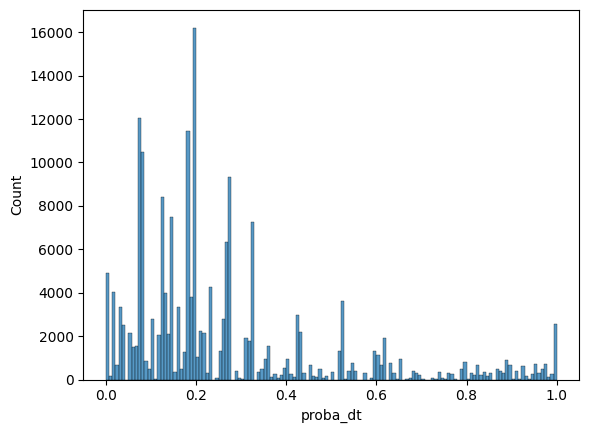

In [44]:
sns.histplot(df_full['proba_dt']);

In [45]:
thresholds = [84, 92]
for threshold in thresholds:
    df_full[f'pred_dt_{threshold}'] = (df_full['proba_dt'] >= threshold/100).astype(int)

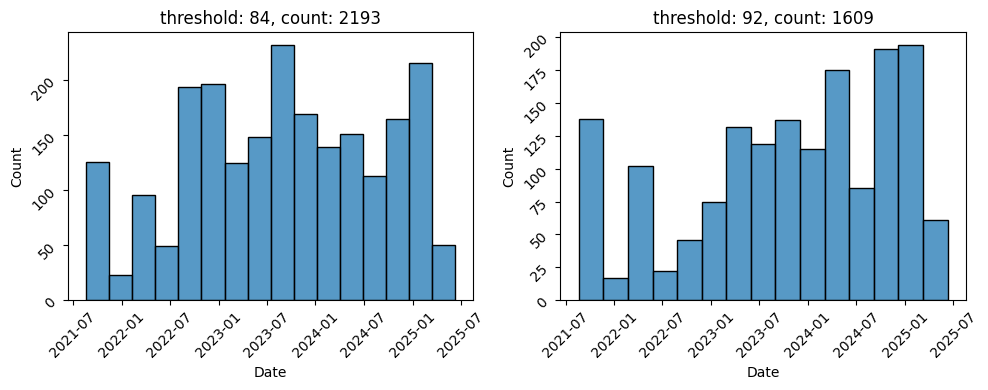

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = axes.reshape(-1)
for i, threshold in enumerate(thresholds):
    df_sub = df_full.query(f"(split == 'test') & (pred_dt_{threshold} == 1)") 
    f= sns.histplot(df_sub['Date'], ax=axes[i]).set_title(f"threshold: {threshold}, count: {len(df_sub)}")
    axes[i].tick_params(labelrotation=45)
plt.tight_layout()

# 5. Random Forest

In [47]:
rf_best_max_depth = 19

In [48]:
%%time
model_rf = RandomForestClassifier(max_depth=rf_best_max_depth, n_estimators=50, n_jobs=-1,random_state=42)
model_rf.fit(X_train_valid, y_train_valid)

CPU times: user 2min 15s, sys: 389 ms, total: 2min 15s
Wall time: 35.6 s


RandomForestClassifier(max_depth=19, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [49]:
df_full['proba_rf'] = model_rf.predict_proba(X_all)[:,1]
df_full['pred_rf'] = model_rf.predict(X_all)

In [50]:
y_pred_proba = model_rf.predict_proba(X_test)[:,1]

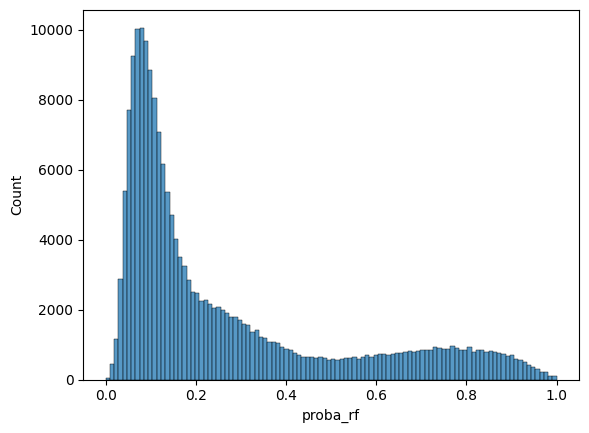

In [51]:
sns.histplot(df_full['proba_rf']);

### Construct the tpr_fpr_dataframe for the Random Forest classifier

In [52]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [53]:
df_scores = tpr_fpr_dataframe(y_test, y_pred_proba, only_even=True)
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,7411,23997,0,0,0.235959,1.000000,0.235959,0.381823,1.000000,1.000000
1,0.02,7411,23997,0,0,0.235959,1.000000,0.235959,0.381823,1.000000,1.000000
2,0.04,7411,23997,0,0,0.235959,1.000000,0.235959,0.381823,1.000000,1.000000
3,0.06,7411,23993,0,4,0.235989,1.000000,0.236086,0.381863,1.000000,0.999833
4,0.08,7408,23980,3,17,0.236014,0.999595,0.236405,0.381866,0.999595,0.999292
5,0.10,7398,23927,13,70,0.236169,0.998246,0.237774,0.381970,0.998246,0.997083
6,0.12,7371,23773,40,224,0.236675,0.994603,0.241817,0.382363,0.994603,0.990665
7,0.14,7317,23436,94,561,0.237928,0.987316,0.250828,0.383450,0.987316,0.976622
8,0.16,7202,22824,209,1173,0.239859,0.971799,0.266652,0.384753,0.971799,0.951119
9,0.18,6977,21828,434,2169,0.242215,0.941438,0.291200,0.385299,0.941438,0.909614


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=14)'}, xlabel='threshold'>

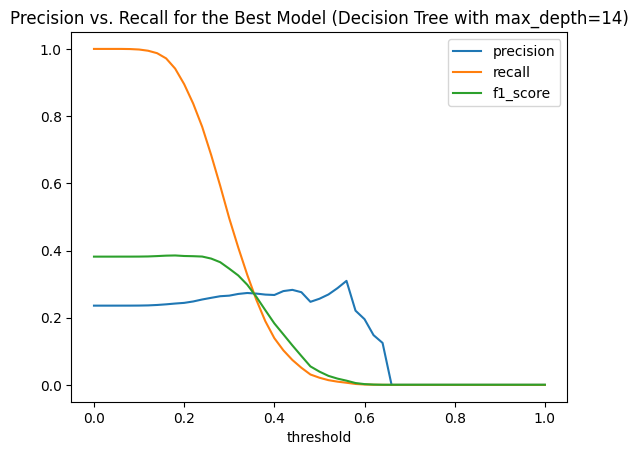

In [54]:
df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=14)')

In [55]:
thresholds = [55,65]
for threshold in thresholds:
    df_full[f'pred_rf_{threshold}'] = (df_full['proba_rf'] >= threshold/100).astype(int)

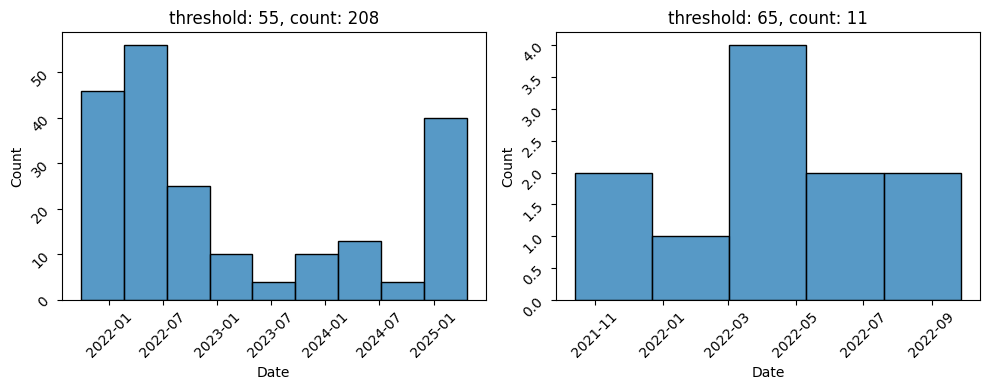

In [56]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = axes.reshape(-1)
for i, threshold in enumerate(thresholds):
    df_sub = df_full.query(f"(split == 'test') & (pred_rf_{threshold} == 1)") 
    f= sns.histplot(df_sub['Date'], ax=axes[i]).set_title(f"threshold: {threshold}, count: {len(df_sub)}")
    axes[i].tick_params(labelrotation=45)
plt.tight_layout()

In [57]:
pred_rf_daily_positive_count = df_full.query(f"(split == 'test') & (pred_rf_65 == 1)").groupby('Date')['pred_rf_65'].count()
pred_rf_daily_positive_count.head()

Date
2021-10-14    1
2021-12-08    1
2022-02-11    1
2022-03-09    1
2022-03-14    1
Name: pred_rf_65, dtype: int64

<Axes: >

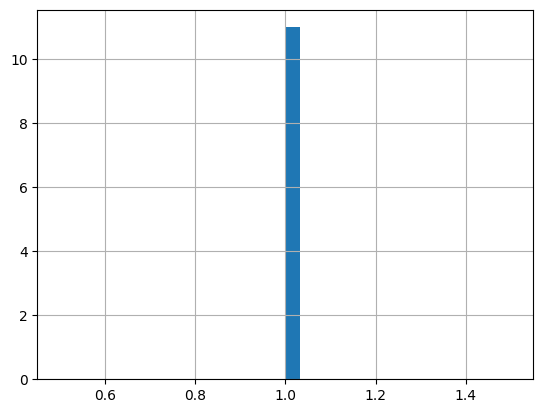

In [58]:
pred_rf_daily_positive_count.hist(bins=30)

# 6. Trading simulation

In [59]:
df_full.columns[-10:]

Index(['month_wom_September_w5', 'split', 'proba_dt', 'pred_dt', 'pred_dt_84',
       'pred_dt_92', 'proba_rf', 'pred_rf', 'pred_rf_55', 'pred_rf_65'],
      dtype='object')

### Investing $100 on every positive prediction

In [60]:
def calculate_simulation(pred_column, verbose=True):
   
    # Fin. result columns: define new records for EACH positive prediction
    df_full['gross_rev'] = df_full[pred_column] * 100 * (df_full['growth_future_30d'] - 1)
    df_full['fees'] = -df_full[pred_column] * 100 * 0.002
    df_full['net_rev'] = df_full['gross_rev'] + df_full['fees']

    df_test = df_full.query("split == 'test'") # filter records on TEST set
    df_test_pred = df_test[df_test[pred_column] == 1] # when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)

    # calculate agg. results for each PREDICTION columns (pred) on TEST
    count_investments = len(df_test_pred)
    gross_rev = df_test_pred['gross_rev'].sum()
    fees = df_test_pred['fees'].sum()
    net_rev = df_test_pred['net_rev'].sum()

    # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
    df_investments_count_daily = df_test_pred.groupby('Date', as_index=False)[pred_column].count()
    avg_investments_per_day = df_investments_count_daily[pred_column].mean()
    q75_investments_per_day = df_investments_count_daily[pred_column].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
    capital = 100 * 30 * q75_investments_per_day # 30 (trading) days  in a row with positive predictions
    
    # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
    CAGR = ((capital + net_rev) / capital)**(1/4)

    revenue = round(100*net_rev / capital,2) 

    results.append([pred_column,count_investments,int(gross_rev),int(fees),int(net_rev),avg_investments_per_day,capital,round(CAGR,4),revenue])

    # output for all predictions with some positive predictions
    if  verbose and count_investments > 1:
        print(f'Calculating sumulation for prediction {pred_column}:')
        print(f"    Count times of investment {len(df_test_pred)} out of {len(df_test)} TEST records")
        print(f"    Financial Result:")
        print(f"        Count Investments in 4 years (on TEST): {count_investments}")
        print(f"        Gross revenue: {gross_rev:.2f} $")
        print(f"        Fees: {fees:.2f} $")
        print(f"        Net revenue: {net_rev:.2f} $")
        print(f"        Fees are {-100.0*fees/gross_rev:.2f} % from Gross Revenue")
        print(f"        Capital Required : {capital} $ (Vbegin)")
        print(f"        Final value (Vbegin + Net_revenue) : {capital + net_rev:.2f} $ (Vfinal)")
        print(f"        >>> Final revenue : {revenue} %")
        print(f"        Average CAGR on TEST (4 years) : {CAGR:.4f}, or {100*(CAGR-1):.1f}% ")

        print(f"        Average daily stats: ")
        print(f"            Average net revenue per investment: {net_rev/count_investments:.2f} $ ")
        print(f"            Average investments per day: {avg_investments_per_day:.2f} $ ")
        print(f"            Q75 investments per day: {q75_investments_per_day:.2f} $")

In [61]:
results = []

In [62]:
calculate_simulation('pred_dt')

Calculating sumulation for prediction pred_dt:
    Count times of investment 6403 out of 31408 TEST records
    Financial Result:
        Count Investments in 4 years (on TEST): 6403
        Gross revenue: 18623.32 $
        Fees: -1280.60 $
        Net revenue: 17401.12 $
        Fees are 6.88 % from Gross Revenue
        Capital Required : 30000.0 $ (Vbegin)
        Final value (Vbegin + Net_revenue) : 47401.12 $ (Vfinal)
        >>> Final revenue : 58.0 %
        Average CAGR on TEST (4 years) : 1.1212, or 12.1% 
        Average daily stats: 
            Average net revenue per investment: 2.72 $ 
            Average investments per day: 6.73 $ 
            Q75 investments per day: 10.00 $


In [63]:
for column in ['pred_dt_84','pred_dt_92','pred_rf','pred_rf_55','pred_rf_65']:
    calculate_simulation(column, False)

In [64]:
df_result = pd.DataFrame(results, columns=['prediction', 'count_investments', 'gross_rev, $', 'fees, $', 'net_rev, $', 'avg_investments_per_day','capital','CAGR', "revenue,%"])
df_result.sort_values(by='CAGR', ascending=False)

,prediction,count_investments,"gross_rev, $","fees, $","net_rev, $",avg_investments_per_day,capital,CAGR,"revenue,%"
0,pred_dt,6403,18623,-1280,17401,6.732913,30000.0,1.1212,58.00
1,pred_dt_84,2193,4311,-438,3876,2.694103,12000.0,1.0725,32.31
3,pred_rf,620,1980,-124,1857,1.680217,6000.0,1.0697,30.95
2,pred_dt_92,1609,2552,-321,2235,2.345481,9000.0,1.0570,24.83
4,pred_rf_55,208,705,-41,664,1.253012,3000.0,1.0513,22.14
5,pred_rf_65,11,-53,-2,-55,1.000000,3000.0,0.9953,-1.85


### Write down the CAGR for the best predictor. 

### 1.1212

* CAGR is decreased to the original best CAGR of 1.1556.
* 6403 trades per day if fewer then 11508 before